#UFMG - Trabalho Prático 2 - Aprendizado de Máquina

Aluno: Paulo Henrique de Souza Coelho

O objetivo desse trabalho prático é ganhar experiência com o processo de Boosting. Aqui será implementado o processo de Boosting visto em sala de aula, o algoritmo Adaboost para um problema de classificação binária com atributos categóricos. O dataset utilizado será o tic-tac-toe, disponível em https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame. Esse dataset contém vários jogos da velha e o objetivo é estimar quando o jogador que joga com 'x' vence.


---

#AdaBoost

Adaboost é um método de aprendizado de emsemble criado inicialmente para aumentar a eficiência de classificadores binários. Adaboost usa uma abordagem iterativa para aprender a partir dos erros de classificadores fracos (weak classifiers), combinando as repostas para criar classificadores fortes.

Aprendizado de esemble é uma técnica de aprendizado de máquina que combina vários algoritmos base para formar um algoritmo preditivo otimizado. Exemplos de ensemble algorimtos são Decision Tree e Adaboost.








In [ ]:
#Importando pacotes

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
 
SEED=500

#Funções de apoio

A função calcula_erro irá calcular a soma dos pesos das observações presentes nos dados onde determinada decision stump errou.

A função calcula_alpha irá calcular o peso do classificador fraco no classificador final, o que é chamado de alpha.

A função atualiza_pesos irá aumentar os pesos das observações onde a previsão da stump está errada para que não seja provável que essas observações estejam erradas na próxima iteração.

In [ ]:
    '''
    Calcula a taxa de erro de um classificador fraco m. Argumentos:
    y = valor do alvo
    y_pred = valor previsto pelo classificador fraco
    w_i: pesos individuais para cada observação
    '''
def calcula_erro(y, y_pred, w_i):
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

    '''
    Calcula o peso do classificador fraco m no voto majoritário do classificador final. 
    Isso é chamado de alpha. Argumentos:
    error = taxa de erro do classificador fraco m
    '''

def calcula_alpha(error):
    return np.log((1 - error) / error)

    ''' 
    Atualiza os pesos individuais w_i após a iteração do boosting. Argumentos:
    w_i = pesos individuais para cada obsrvação
    y = valor da variável alvo
    y_pred = valor previso pelo classificador fraco
    alpha = peso do classificador fraco usado para estimar y_pred
    '''

def atualiza_pesos(w_i, alpha, y, y_pred):   
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

#Implementação AdaBoost

Implementando o AdaBoost utilzando uma classe. Como classificador fraco será utilizado o classificador do scikitlearn Decision Tree Classifier com pofundidade máxima de 1.

A classe possui os métodos fit, que irá ser utilizado para treinar o modelo,
método predict que irá prever valores da classe utilziando os dados de teste e o método error_rates que retorna o valor da taxa de erro da classe.

A classe também contém outras informações relevantes para o modelo, como a sequência de classificadores fracos e seus pesos bem como os erros de treino e predição. Esses valores são iniciados como listas vazias na inicialização da classe.


In [ ]:
class AdaBoost:

  def __init__(self, M=100):
  
    '''
    M: Número de rodadas de boosting. Default é 100    
    '''
    
    self.alphas = []
    self.G_M = []
    self.M = None
    self.erro_de_treino = []
    self.erro_de_predicao = []
    self.M = M

  def fit(self, X, y):
    '''
    Fitar modelo. Argumentos:
    X: variáveis independentes - vetor tipo array
    y: variáveis alvo - vetor tipo array  
    '''
  
    self.alphas = [] 
    self.erro_de_treino = []

    for m in range(0, self.M):        
      if m == 0:
          w_i = np.ones(len(y)) * 1 / len(y)
      else:
          w_i = atualiza_pesos(w_i, alpha_m, y, y_pred)

      G_m = DecisionTreeClassifier(max_depth = 1)
      G_m.fit(X, y, sample_weight = w_i)
      y_pred = G_m.predict(X)
      
      self.G_M.append(G_m)
      
      error_m = calcula_erro(y, y_pred, w_i)
      self.erro_de_treino.append(error_m)

      alpha_m = calcula_alpha(error_m)
      self.alphas.append(alpha_m)

    assert len(self.G_M) == len(self.alphas)

  def predict(self, X):
    '''
    Previsões usando o modelo. Argumentos:
    X: variáveis independentes - tipo array
    '''

    weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

    for m in range(self.M):
        y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
        weak_preds.iloc[:,m] = y_pred_m

    y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

    return y_pred

  def error_rates(self, X, y):
      '''
      Pega a taxa de erro de cada classificador fraco. Argumentos:
      X = variáveis independentes
      y = variáveis alvo associadas a X
      '''
      
      self.erro_de_predicao = []
     
      for m in range(self.M):
          y_pred_m = self.G_M[m].predict(X)          
          error_m = calcula_erro(y = y, y_pred = y_pred_m, w_i = np.ones(len(y)))
          self.erro_de_predicao.append(error_m)

#Executa validação cruzada

Essa função irá realizar a validação cruzada para cada um dos 5 folds utilizando a função StratifiedKfold, um objeto de validação cruzada pertencente à biblioteca sklearn e retorna folds estratificados. Os folds são feitos prevervando a porcentagem de amostras de cada classe.

Para cada número de iterações são realizadas 5 folds, o modelo é fitado passando o valor de M que reflete o número de classificadores fracos (ou rounds de boosting) como o valor de num_iterações.

Os valores de previsão são obtidos utilizando a função predict e a acurácia é calculada utilizando a função acuracy_score do sickitlearn.


In [ ]:
def executa_validacao_cruzada(X, y, num_iteracoes, cv = 5):
  validacao_cruzada = StratifiedKFold(n_splits = cv, shuffle = True, random_state = SEED)
  lst_acuracia = []

  iteracao_fold = 1
  # para cada conjunto de 4 folds é ajustado o classificador, depois ajustada as metricas no fold de teste
  for treino, teste in validacao_cruzada.split(X, y):
  # ajustando o classificador
    classificador_adaboost = AdaBoost(M = num_iteracoes)
    classificador_adaboost.fit(X = X.iloc[treino], y = y.iloc[treino])

    predicao_adaboost_teste = classificador_adaboost.predict(X.iloc[teste])    
    acuracia = accuracy_score(y.iloc[teste], predicao_adaboost_teste) * 100

    lst_acuracia.append(acuracia)
    iteracao_fold += 1
  print("Validação cruzada com número de iterações igual a {} executada com sucesso.".format(num_iteracoes))
  return {'acuracia': lst_acuracia}


#Leitura dos dados e execução

A leitura dos dados é realizada utlizando um link do github com os dados de jogo da velha (tic tac toe). Os dados estão em string que indica se o jogador utilizou x, o ou deixou em branco (b). Esses valores são transformados em números de 0 a 2, já o valor de y está em postive e negative indicando se o jogador ganhou ou perdeu o jogo. Os valores são mudados para 1 e -1.

Os dados são separados em treino e teste utlizando o train_test_split do sciktlearn. Também são definidos os números de interações para a validação cruzada, variando de 1 a 500, valores que serão utilizados para definir o número de classificadores fracos na classe AdaBoosting.

Para cada número de interação é realizada a validação cruzada definida no bloco de código anterior. Os valores são adicionados a uma lista.

In [ ]:
url = "https://raw.githubusercontent.com/paulohdscoelho/ml/master/TP2/tic-tac-toe.data"
data = pd.read_csv(url, delimiter=',')
symbol_to_id = {'x':0, 'o':1, 'b':2, 'positive':1, 'negative':-1}
data = data.applymap(lambda x: symbol_to_id[x])

x, y = data.drop('resposta', axis=1), data['resposta']

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, random_state = SEED, test_size = 0.3, stratify = y)
treino_x = treino_x.values
teste_x = teste_x.values

lst_num_iteracoes = [1, 2, 5, 10, 20, 50, 100, 200, 500]
resultados_validacao_cruzada = [executa_validacao_cruzada(x, y, i) for i in lst_num_iteracoes]

Validação cruzada com número de iterações igual a 1 executada com sucesso.
Validação cruzada com número de iterações igual a 2 executada com sucesso.
Validação cruzada com número de iterações igual a 5 executada com sucesso.
Validação cruzada com número de iterações igual a 10 executada com sucesso.
Validação cruzada com número de iterações igual a 20 executada com sucesso.
Validação cruzada com número de iterações igual a 50 executada com sucesso.
Validação cruzada com número de iterações igual a 100 executada com sucesso.
Validação cruzada com número de iterações igual a 200 executada com sucesso.
Validação cruzada com número de iterações igual a 500 executada com sucesso.


#Valores do classificador

Abaixo é mostrado de maneira tabelar os valores de acurácia que o classificador obteve para cada um dos splits, bem como a acuŕacia méida e o desvio padrão para cada número de iterações utiilizada na cross-validation. O valor de iterações é aqui o número de vezes que o modelo irá executar a correção de pesos dado os valores de treino, ou seja, quanto mais iterações, mais o modelo converge para uma separação eficiente dos dados.

Nota-se que o valor da acurácia para todos os k-folds (split) aumenta à medica que o número de iterações aumenta. Notadamente, como 1 iteração a acurácia média fica em 65,35%, já com 500 iterações o valor aumenta para 95,93%. 


In [ ]:
df_acuracia = pd.DataFrame({
    'num_iteracoes': lst_num_iteracoes,
    'acuracia_teste_split0': [resultados_validacao_cruzada[item]['acuracia'][0] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split1': [resultados_validacao_cruzada[item]['acuracia'][1] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split2': [resultados_validacao_cruzada[item]['acuracia'][2] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split3': [resultados_validacao_cruzada[item]['acuracia'][3] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_split4': [resultados_validacao_cruzada[item]['acuracia'][4] for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_media': [np.mean(resultados_validacao_cruzada[item]['acuracia']) for item in range(len(lst_num_iteracoes))],
    'acuracia_teste_std': [np.std(resultados_validacao_cruzada[item]['acuracia']) for item in range(len(lst_num_iteracoes))]})

df_acuracia

,num_iteracoes,acuracia_teste_split0,acuracia_teste_split1,acuracia_teste_split2,acuracia_teste_split3,acuracia_teste_split4,acuracia_teste_media,acuracia_teste_std
0,1,65.625000,65.104167,65.104167,65.445026,65.445026,65.344677,0.207080
1,2,65.625000,58.333333,65.104167,60.209424,65.445026,62.943390,3.060894
2,5,69.270833,66.666667,72.916667,68.062827,72.774869,69.938373,2.513296
3,10,76.562500,67.708333,80.729167,77.486911,76.963351,75.890052,4.347681
4,20,73.437500,72.395833,77.604167,69.109948,78.534031,74.216296,3.467446
5,50,74.479167,70.312500,75.000000,71.727749,73.821990,73.068281,1.770964
6,100,77.604167,72.916667,78.645833,75.392670,77.486911,76.409250,2.040738
7,200,83.854167,80.729167,86.458333,81.675393,90.052356,84.553883,3.384196
8,500,96.875000,94.791667,97.916667,92.670157,97.382199,95.927138,1.942735


Abaixo é apresentado um gráfico para os valores exibidos na tabela acima. No caso, é apresentada a variação de acurácia média conforme se varia o número de iterações.
Fica graficamente óbvio que os valores de acurácia média sobem à medida que o número de iterações também sobe. Isso acontece porque o modelo irá treinar mais os dados, corrigindo o valor dos pesos até convergir em um modelo de acurácia alta.

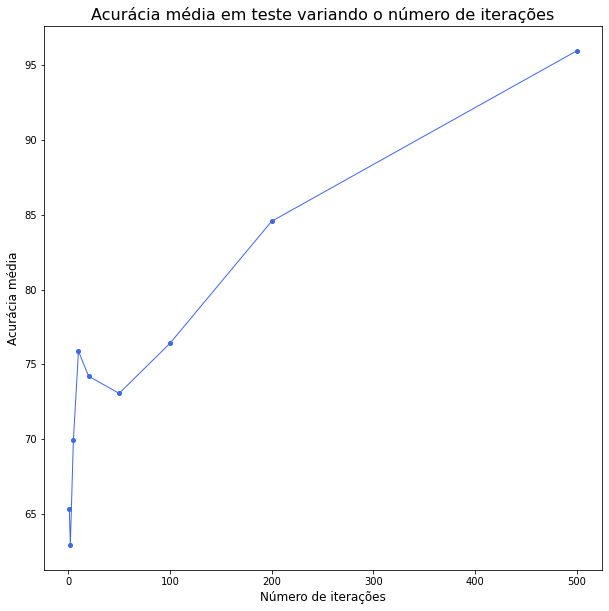

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot('num_iteracoes', 'acuracia_teste_media', data = df_acuracia, 
         marker = 'o', markerfacecolor = 'royalblue', markersize = 4, 
         color = 'royalblue', linewidth = 1)
plt.title('Acurácia média em teste variando o número de iterações', fontsize = 16)
plt.xlabel('Número de iterações', fontsize = 12)
plt.ylabel('Acurácia média', fontsize = 12)
axes = plt.gca()
plt.show()

#Acurácia do modelo e taxa de erro por stump

Nessa seção são avaliados os valores da curva de Receiver Operating Characteristic (ROC) e o Area Under the Curve (AUC), também conhecido como ROC-AUC. Nota-se que o valor é bastante elevado, chegando a 95%. É utilizado um adaboost com valor de M igual a 500, por ter sido o número de iterações que obteve melhor valor de acurácia nas secões anteriores.

Também é exibido os valores do Report de classificação do modelo. Nota-se que a precisão do modelo é bastante elevada (a precisão chega a 100% para o valor de -1 e 95% para 1). Já o recall possui um valor de 91% para a classe -1 e 100% para a classe 1. o F1-score também é elevado e a acurácia do modelo atinge 95% e 98%.

Abaixo é plotado um gráfico contendo a taxa de erro por cada stump do modelo. Nota-se que o valor inicialmente é baixo e cresce entre os valores de 0 a 50 stumps, atingindo um valor alto a partir de 50 stumps e variando de forma consistente à medida que o número de stumps aumenta.

O score ROC-AUC do modelo é: 0.955
Relatório de classificação: 
               precision    recall  f1-score   support

          -1       1.00      0.91      0.95       100
           1       0.95      1.00      0.98       188

    accuracy                           0.97       288
   macro avg       0.98      0.96      0.96       288
weighted avg       0.97      0.97      0.97       288



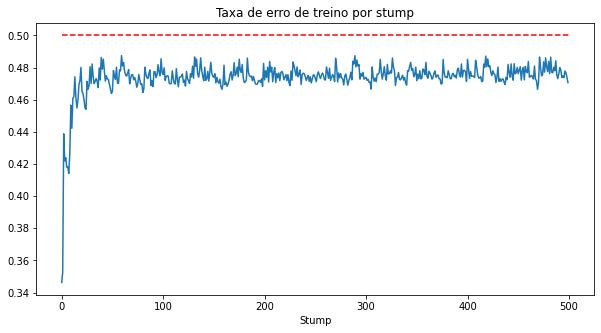

In [ ]:
ab = AdaBoost(M = 500)
ab.fit(treino_x, treino_y)

y_pred = ab.predict(teste_x)
print('O score ROC-AUC do modelo é:', round(roc_auc_score(teste_y, y_pred), 4))
print("Relatório de classificação: \n", classification_report(teste_y, y_pred))

plt.figure(figsize=(10,5))
plt.plot(ab.erro_de_treino)
plt.hlines(0.5, 0, 500, colors = 'red', linestyles='dashed')
plt.title('Taxa de erro de treino por stump')
plt.xlabel('Stump')
plt.show()